## Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os
from datetime import datetime, timedelta
import multiprocessing

In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    data_path = "/datax/scratch/nstieg/"
elif hostname == "cosmic-gpu-1":
    data_path = "/mnt/cosmic-gpu-1/data0/nstiegle/"
else:
    raise Exception("Data path not known")

full_dataset_path = data_path + "25GHz_higher.pkl"
coherent_dataset_path = data_path + "25GHz_higher_coherent.pkl"
incoherent_dataset_path = data_path + "25GHz_higher_incoherent.pkl"

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

In [3]:
# All data
# # Load in distance and mask
# path = "/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_all/"
# distances_path = path + "all_within_1000hz.distances.npz"
# mask_path = path + "all_within_1000hz.mask.npz"
# distances = load_npz(distances_path)
# mask = load_npz(mask_path)
# print(distances.shape)
# print(mask.shape)

# Coherent, by source data
# Load in all the distances and masks to a np array of [[distances, mask], ...] for each source
# path = os.path.expanduser("~") + "/" + "BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_each_source/" # Place to save arrays
# files = os.listdir(path) # All the files and directories in the folder
# files = [f for f in files if os.path.isfile(path + '/' + f)] # Just get the folders
# files = [f.split('.') for f in files] # Take off the extension
# files = np.array(files) # Turn into a numpy array so I can slice off the extensions
# files = np.unique(files[:, 0]) # Get the unique filenames (sources observed)
# sources_data = [] # Append (source.distances.npz, source.mask.npz)
# sources = []
# for file in files:
#     distances = load_npz(path + "/" + file + ".distances.npz")
#     mask = load_npz(path + "/" + file + ".mask.npz")
#     sources_data.append((distances, mask))
#     sources.append(file.split('_')[0])

# sources_data = np.array(sources_data, dtype='object')

## Coherent Filters

### Filter 1

In [123]:
# The filter (for filter 1) to run on a single group of frequencies to see if they
# count as RFI or not
# Takes:
# - A df containing hits from a single source all at the same frequency
# Returns:
# - True if those hits don't count as RFI or false if they do
def pass_filter1_single_group(group):
    if len(group) == 1:
        # No other hit at this frequency, could be a genuine signal
        return True
    else:
        unique_drs = group.signal_drift_rate.unique()
        # Not all hits had 0 drift rate
        return (len(unique_drs) != 1) or (0 not in unique_drs)

# Run filter one on a single source
# A part of the filter one algorithm
# Parameters:
# - source: The df of source from the coherent data
# Returns the ids of the hits which pass the filter
def filter1_single_source(source, name=None):
    source_good_ids = np.array([], dtype=int) # Put all the good ids from this source
    
    # Put things into groups of frequencies which are *exactly* the same
    groups = source.groupby("signal_frequency")
    for f, group in groups:
        if pass_filter1_single_group(group):
            source_good_ids = np.concatenate((source_good_ids, group.id.values))

    # Log
    if name != None:
        print("Done with: " + name)

    return source_good_ids

# Apply filter one
# Extend COSMIC's ability to detect zero drift rate RFI
# Removes hits from a single target which are at exactly the same frequency as other hits 
# from that target and where all the hits detected at that frequency have a zero drift rate
# Parameters:
# - coherent: The df of coherent data
# Returns the ids of the hits which pass the filter
def filter1(coherent):
    # What we're going to return
    good_ids = np.array([], dtype=int) # Place to store all the good ids we find
    
    # Filter by each source
    sources = coherent.groupby("source_name")
    for source_name, source in sources:
        print("On source", source_name)
        source_good_ids = filter1_single_source(source)
        good_ids = np.concatenate((good_ids, source_good_ids))

    return good_ids

#### Test Filter 1

In [110]:
# Get a list of frequency groups from the first dataset
sources = list(coherent.groupby("source_name"))
source_name, source = sources[0]
groups = list(source.groupby("signal_frequency"))

single_zero_group = groups[0][1] # Just one zero
single_mixed_group = groups[8][1] # just one nonzero
many_zero_group = groups[14][1] # Has many zeros, shouldn't pass
many_mixed_group = groups[82][1] # Has some zeros and some nonzeros, should pass

In [124]:
assert(pass_filter1_single_group(single_zero_group))
assert(pass_filter1_single_group(single_mixed_group))
assert(not pass_filter1_single_group(many_zero_group))
assert(pass_filter1_single_group(many_mixed_group))

#### Mess around with filter 1

In [7]:
first_source = coherent[coherent['source_name'] == coherent["source_name"][0]]
good_ids = filter1_single_source(first_source)

In [8]:
print(good_ids.shape, "good ids")
print(f"{round(len(good_ids) / len(first_source) * 100, 3)}% of ids good")

(29936,) good ids
41.912% of ids good


In [9]:
first_source_ids = first_source.set_index("id")
assert(len(first_source) == len(first_source_ids))
good_data = first_source_ids.loc[good_ids]
assert(len(good_data) == len(good_ids))

#### multprocess filter 1

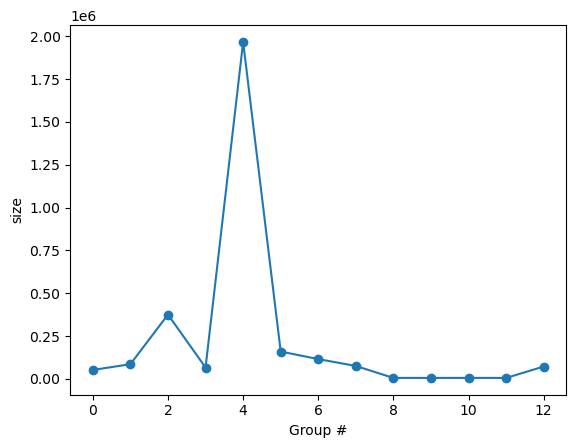

In [41]:
# So we could just run each source individually, right?
# Let's see how big the sources are. The biggest one will 
# be our limiting factor
sources = coherent.groupby("source_name")
sizes = [len(source) for _, source in sources]
plt.plot(sizes, marker='o')
plt.xlabel("Group #")
plt.ylabel("size")
plt.show()

In [33]:
# Try multiprocessing on just the first two (small ones)

# Create input array
inputs = [(source, source_name) for source_name, source in sources] 

# # creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
results = p.starmap(filter1_single_source, inputs[:2])

good_indices_2 = np.array([], dtype=int)
for result in results:
    good_indices_2 = np.concatenate([good_indices_2, result])

print(good_indices_2)
print(good_indices_2.shape)

Done with: 2535280716217508992
Done with: 2536546185381558272
[987229837 987228147 987285463 ... 953252868 953396087 953400863]
(42518,)


### Filter 2

In [129]:
# The filter (for filter 2) to run on a single group of frequencies to see if they
# count as RFI or not
# Takes:
# - A df containing hits from a single source all at the same frequency
# Returns:
# - True if those hits don't count as RFI or false if they do
def pass_filter2_single_group(group):
    if len(group) == 1:
        # No other hit at this frequency, could be a genuine signal
        return True
    else:
        unique_drs = group.signal_drift_rate.unique()
        
        # There is a drift rate greater than or equal to 0.25Hz/s
        return max(abs(unique_drs)) >= 0.25

# Run filter two on a single source
# A part of the filter two algorithm
# Parameters:
# - source: The df of source from the coherent data
# Returns the ids of the hits which pass the filter
def filter2_single_source(source, name=None):
    source_good_ids = np.array([], dtype=int) # Put all the good ids from this source
    
    # Put things into groups of frequencies which are *exactly* the same
    groups = source.groupby("signal_frequency")
    for f, group in groups:
        if pass_filter2_single_group(group):
            source_good_ids = np.concatenate((source_good_ids, group.id.values))

    # Log
    if name != None:
        print("Done with: " + name)

    return source_good_ids

# Apply filter two
# Extend COSMIC's ability to detect zero drift rate RFI
# Removes hits from a single target which are at exactly the same frequency as other hits 
# from that target and where all the hits detected at that frequency have a zero drift rate
# or close to zero drift rate (|DR| < 0.25Hz/s)
# Parameters:
# - coherent: The df of coherent data
# Returns the ids of the hits which pass the filter
def filter2(coherent):
    # What we're going to return
    good_ids = np.array([], dtype=int) # Place to store all the good ids we find
    
    # Filter by each source
    sources = coherent.groupby("source_name")
    for source_name, source in sources:
        print("On source", source_name)
        source_good_ids = filter1_single_source(source)
        good_ids = np.concatenate((good_ids, source_good_ids))

    return good_ids

In [139]:
# for i, group in enumerate(groups):
#     f, group = group
#     if len(group) > 1 and len(group.signal_drift_rate.unique()) > 1 and max(abs(group.signal_drift_rate.unique())) >= 0.25:
#         print("index:", i, "num_hits", len(group), "max dr:", max(abs(group.signal_drift_rate.unique())))

high_dr_group = groups[584][1]
mid_dr_group = groups[492][1]

In [140]:
assert(pass_filter2_single_group(single_zero_group))
assert(pass_filter2_single_group(single_mixed_group))
assert(not pass_filter2_single_group(many_zero_group))
assert(not pass_filter2_single_group(many_mixed_group))
assert(pass_filter2_single_group(high_dr_group))
assert(pass_filter2_single_group(mid_dr_group))


## All data filters

In [10]:
groups = coherent.groupby('source_name')
group = groups.get_group(coherent.source_name[0])
groups = group.groupby("signal_frequency")
group = groups.get_group(coherent.signal_frequency[0])


numpy.ndarray

In [13]:
a = np.array([], dtype=int)
print(a)
print(group.id.values)
b = np.concatenate([a, group.id.values])
print(b)

[]
[900273190]
[900273190]


In [20]:
groups = coherent.groupby("signal_frequency")
print(len(groups))
filtered_groups = groups.filter(lambda x: len(x) > 1)
print(len(filtered_groups))

2410430
655765


In [23]:
np.save("/home/nstieg/BL-COSMIC-2024-proj/filters/filter5" + "/run_filter_5_coherent_results", filtered_groups.id.values)